# Recognize named entities on Twitter with LSTMs

In this assignment, you will use a recurrent neural network to solve Named Entity Recognition (NER) problem. NER is a common task in natural language processing systems. It serves for extraction such entities from the text as persons, organizations, locations, etc. In this task you will experiment to recognize named entities from Twitter.

For example, we want to extract persons' and organizations' names from the text. Than for the input text:

    Ian Goodfellow works for Google Brain

a NER model needs to provide the following sequence of tags:

    B-PER I-PER    O     O   B-ORG  I-ORG

Where *B-* and *I-* prefixes stand for the beginning and inside of the entity, while *O* stands for out of tag or no tag. Markup with the prefix scheme is called *BIO markup*. This markup is introduced for distinguishing of consequent entities with similar types.

A solution of the task will be based on neural networks, particularly, on Bi-Directional Long Short-Term Memory Networks (Bi-LSTMs).

### Libraries

For this task you will need the following libraries:
 - [Tensorflow](https://www.tensorflow.org) — an open-source software library for Machine Intelligence.
 
In this assignment, we use Tensorflow 1.15.0. You can install it with pip:

    !pip install tensorflow==1.15.0
     
 - [Numpy](http://www.numpy.org) — a package for scientific computing.
 
If you have never worked with Tensorflow, you would probably need to read some tutorials during your work on this assignment, e.g. [this one](https://www.tensorflow.org/tutorials/recurrent) could be a good starting point. 

### Data

The following cell will download all data required for this assignment into the folder `week2/data`.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    ! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.setup_week2()

import sys
sys.path.append("..")
from common.download_utils import download_week2_resources

download_week2_resources()

File data\train.txt is already downloaded.
File data\validation.txt is already downloaded.
File data\test.txt is already downloaded.


### Load the Twitter Named Entity Recognition corpus

We will work with a corpus, which contains tweets with NE tags. Every line of a file contains a pair of a token (word/punctuation symbol) and a tag, separated by a whitespace. Different tweets are separated by an empty line.

The function *read_data* reads a corpus from the *file_path* and returns two lists: one with tokens and one with the corresponding tags. You need to complete this function by adding a code, which will replace a user's nickname to `<USR>` token and any URL to `<URL>` token. You could think that a URL and a nickname are just strings which start with *http://* or *https://* in case of URLs and a *@* symbol for nicknames.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def read_data(file_path):
    tokens = []
    tags = []
    
    tweet_tokens = []
    tweet_tags = []
    for line in open(file_path, encoding='utf-8'):
        line = line.strip()
        if not line:
            if tweet_tokens:
                tokens.append(tweet_tokens)
                tags.append(tweet_tags)
            tweet_tokens = []
            tweet_tags = []
        else:
            token, tag = line.split()
            # Replace all urls with <URL> token
            # Replace all users with <USR> token
            ######################################
            ######### YOUR CODE HERE #############
            ######################################
            if token[0] == '@':
                token = "<USR>"
            if token[:4] == 'http':
                token = "<URL>"
            
            tweet_tokens.append(token)
            tweet_tags.append(tag)
            
    return tokens, tags

And now we can load three separate parts of the dataset:
 - *train* data for training the model;
 - *validation* data for evaluation and hyperparameters tuning;
 - *test* data for final evaluation of the model.

In [4]:
train_tokens, train_tags = read_data('data/train.txt')
validation_tokens, validation_tags = read_data('data/validation.txt')
test_tokens, test_tags = read_data('data/test.txt')

You should always understand what kind of data you deal with. For this purpose, you can print the data running the following cell:

In [6]:
for i in range(3):
    for token, tag in zip(train_tokens[i], train_tags[i]):
        print('%s\t%s' % (token, tag))
    print()

RT	O
<USR>	O
:	O
Online	O
ticket	O
sales	O
for	O
Ghostland	B-musicartist
Observatory	I-musicartist
extended	O
until	O
6	O
PM	O
EST	O
due	O
to	O
high	O
demand	O
.	O
Get	O
them	O
before	O
they	O
sell	O
out	O
...	O

Apple	B-product
MacBook	I-product
Pro	I-product
A1278	I-product
13.3	I-product
"	I-product
Laptop	I-product
-	I-product
MD101LL/A	I-product
(	O
June	O
,	O
2012	O
)	O
-	O
Full	O
read	O
by	O
eBay	B-company
<URL>	O
<URL>	O

Happy	O
Birthday	O
<USR>	O
!	O
May	O
Allah	B-person
s.w.t	O
bless	O
you	O
with	O
goodness	O
and	O
happiness	O
.	O



### Prepare dictionaries

To train a neural network, we will use two mappings: 
- {token}$\to${token id}: address the row in embeddings matrix for the current token;
- {tag}$\to${tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

Now you need to implement the function *build_dict* which will return {token or tag}$\to${index} and vice versa. 

In [7]:
from collections import defaultdict

In [8]:
def build_dict(tokens_or_tags, special_tokens):
    """
        tokens_or_tags: a list of lists of tokens or tags
        special_tokens: some special tokens
    """
    # Create a dictionary with default value 0
    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    
    # Create mappings from tokens (or tags) to indices and vice versa.
    # At first, add special tokens (or tags) to the dictionaries.
    # The first special token must have index 0.
    
    # Mapping tok2idx should contain each token or tag only once. 
    # To do so, you should:
    # 1. extract unique tokens/tags from the tokens_or_tags variable, which is not
    #    occur in special_tokens (because they could have non-empty intersection)
    # 2. index them (for example, you can add them into the list idx2tok
    # 3. for each token/tag save the index into tok2idx).
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    #Extract unique tokens from tokens_

    tokens_or_tags_list =[]
    
    for i in tokens_or_tags:
        tokens_or_tags_list += i
    
    not_special_tokens_or_tags = list(set(tokens_or_tags_list))
    
    for i in special_tokens:
        if i in not_special_tokens_or_tags:
            not_special_tokens_or_tags.remove(i)
    
    idx2tok = special_tokens + not_special_tokens_or_tags
    
    for i in range(len(idx2tok)):
        tok2idx[idx2tok[i]] = i
    
    return tok2idx, idx2tok

After implementing the function *build_dict* you can make dictionaries for tokens and tags. Special tokens in our case will be:
 - `<UNK>` token for out of vocabulary tokens;
 - `<PAD>` token for padding sentence to the same length when we create batches of sentences.

In [9]:
special_tokens = ['<UNK>', '<PAD>']
special_tags = ['O']

# Create dictionaries 
token2idx, idx2token = build_dict(train_tokens + validation_tokens, special_tokens)
tag2idx, idx2tag = build_dict(train_tags, special_tags)

The next additional functions will help you to create the mapping between tokens and ids for a sentence. 

In [10]:
def words2idxs(tokens_list):
    return [token2idx[word] for word in tokens_list]

def tags2idxs(tags_list):
    return [tag2idx[tag] for tag in tags_list]

def idxs2words(idxs):
    return [idx2token[idx] for idx in idxs]

def idxs2tags(idxs):
    return [idx2tag[idx] for idx in idxs]

### Generate batches

Neural Networks are usually trained with batches. It means that weight updates of the network are based on several sequences at every single time. The tricky part is that all sequences within a batch need to have the same length. So we will pad them with a special `<PAD>` token. It is also a good practice to provide RNN with sequence lengths, so it can skip computations for padding parts. We provide the batching function *batches_generator* readily available for you to save time. 

In [118]:
# tweets de longueur irrégulière ->  <PAD> token
# formalisation de chaque tweet avec un PAD au début et n à la fin

def initialize_data(x_data_in,y_data_in):
    max_length = max([len(i) for i in x_data_in])
    x_data_out = []
    y_data_out = []
    for i in range(len(x_data_in)):
        length = len(x_data_in[i])
        add = (max_length + 1 - length)
        x_data_out.append(x_data_in[i] + ['<PAD>']*add)
        y_data_out.append(y_data_in[i] + ['O']*add)
    
    indexes_x = [words2idxs(i) for i in x_data_out]
    indexes_y = [tags2idxs(i) for i in y_data_out]
    
    return indexes_x,indexes_y
    
def one_hot(y_data):
    y_oh = []
    for i in y_data:
        y_i = [0]*21
        y_i[i] = 1
        y_oh.append(y_i)
    return y_oh


def initialize_input(nb_input,x_data,y_data):
    
    x_data,y_data = initialize_data(x_data,y_data)
    x_data = np.concatenate(x_data)
    y_data = np.concatenate(y_data)
    y_data = one_hot(y_data)
    
    input_i = x_data[:nb_input]
    input_x = [input_i]
    for i in range(nb_input+1,len(x_data)):
        input_i = np.concatenate([input_i[1:],[x_data[i]]])
        input_x.append(input_i)
        
    input_x = np.array(input_x)
    input_y = np.array(y_data[nb_input:])
    input_x = input_x.reshape(input_x.shape[0],1,input_x.shape[1])
    
    return input_x,input_y


x_train,y_train = initialize_data(train_tokens,train_tags)
x_test,y_test = initialize_data(test_tokens,test_tags)
x_val,y_val = initialize_data(validation_tokens,validation_tags)

x_train = np.concatenate(x_train)
y_train = one_hot(np.concatenate(y_train))

x_test = np.concatenate(x_test)
y_test = one_hot(np.concatenate(y_test))

x_val = np.concatenate(x_val)
y_val = one_hot(np.concatenate(y_val))



In [119]:
nb_inputs = 30

x_train,y_train = initialize_input(nb_inputs,train_tokens,train_tags)
x_val,y_val = initialize_input(nb_inputs,validation_tokens,validation_tags)
x_test,y_test = initialize_input(nb_inputs,test_tokens,test_tags)

In [120]:
#y_train = np.array([[0]*21]*len(x_train))
#y_train[:,0] = 1

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [225]:
print(idxs2words(x_train[12][0]))


['PM', 'EST', 'due', 'to', 'high', 'demand', '.', 'Get', 'them', 'before', 'they', 'sell', 'out', '...', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'Apple']


In [226]:
print(idx2tag[np.argmax(y_train[12])])


B-product


## Build a recurrent neural network

This is the most important part of the assignment. Here we will specify the network architecture based on TensorFlow building blocks. It's fun and easy as a lego constructor! We will create an LSTM network which will produce probability distribution over tags for each token in a sentence. To take into account both right and left contexts of the token, we will use Bi-Directional LSTM (Bi-LSTM). Dense layer will be used on top to perform tag classification.  

In [246]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Bidirectional
from keras.layers import Activation

In [287]:
drop = 0.2

#model = Sequential()

#model.add(Bidirectional(LSTM(200, input_shape = (1,x_train.shape[2]))))
#model.add(Dense(21, activation = 'softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

 # With custom backward layer
model = Sequential()
model.add(Bidirectional(LSTM(200), input_shape=(1,x_train.shape[2])))
model.add(Dropout(drop))
model.add(Dense(21))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [285]:
repartition = 1/sum(np.concatenate((y_train,y_val)))
repartition = repartition/sum(repartition)
class_weight = {i : repartition[i] for i in range(21)}

To compute the actual predictions of the neural network, you need to apply [softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax) to the last layer and find the most probable tags with [argmax](https://www.tensorflow.org/api_docs/python/tf/argmax).

## Train the network and predict tags

[Session.run](https://www.tensorflow.org/api_docs/python/tf/Session#run) is a point which initiates computations in the graph that we have defined. To train the network, we need to compute *self.train_op*, which was declared in *perform_optimization*. To predict tags, we just need to compute *self.predictions*. Anyway, we need to feed actual data through the placeholders that we defined before. 

In [296]:
history = model.fit(x_train, y_train, validation_data = (x_val,y_val), epochs=5, batch_size=20000,class_weight=class_weight)

Train on 243360 samples, validate on 27482 samples
Epoch 1/5
243360/243360 [==============================] - 67s 275us/step - loss: 0.0021 - accuracy: 0.6103 - val_loss: 1.7411 - val_accuracy: 0.5984
Epoch 2/5
243360/243360 [==============================] - 54s 222us/step - loss: 0.0021 - accuracy: 0.6089 - val_loss: 1.7496 - val_accuracy: 0.5963
Epoch 3/5
243360/243360 [==============================] - 136s 559us/step - loss: 0.0021 - accuracy: 0.6074 - val_loss: 1.7567 - val_accuracy: 0.5951
Epoch 4/5
243360/243360 [==============================] - 111s 456us/step - loss: 0.0021 - accuracy: 0.6057 - val_loss: 1.7634 - val_accuracy: 0.5941
Epoch 5/5
243360/243360 [==============================] - 101s 413us/step - loss: 0.0021 - accuracy: 0.6047 - val_loss: 1.7694 - val_accuracy: 0.5931


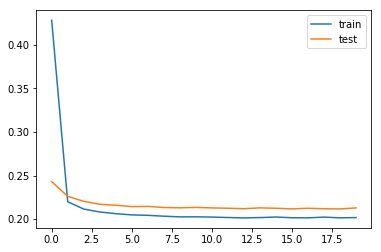

In [294]:
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'],label = 'test')
plt.legend()
plt.show()

Implement the function *predict_for_batch* by initializing *feed_dict* with input *x_batch* and *lengths* and running the *session* for *self.predictions*.

We finished with necessary methods of our BiLSTMModel model and almost ready to start experimenting.

### Evaluation 
To simplify the evaluation process we provide two functions for you:
 - *predict_tags*: uses a model to get predictions and transforms indices to tokens and tags;
 - *eval_conll*: calculates precision, recall and F1 for the results.

In [290]:
resultats = model.predict_classes(x_train)

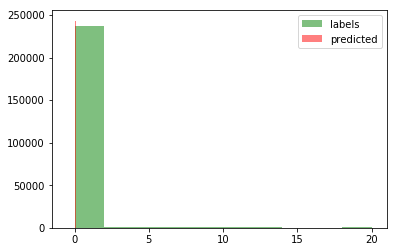

In [295]:
plt.hist(y_train.argmax(axis= 1),alpha = 0.5,color = 'g',label = 'labels')
plt.hist(resultats,alpha = 0.5, color = 'r', label = 'predicted')
plt.legend()
plt.show()

In [282]:
def precision(model,x_data,y_data,resultats):
    #resultats = model.predict_classes(x_data)
    bons = np.zeros(21)
    len_accuracy = np.zeros(21)
    accuracy = np.zeros(21)
    classes = y_data.argmax(axis = 1)
    for i in range(len(resultats)):
        len_accuracy[resultats[i]] +=1
        if classes[i] == resultats[i]:
            bons[resultats[i]] += 1
    for i in range(len(accuracy)):
        if len_accuracy[i] == 0:
            print("classe non prédite")
        else :
            print(str(idx2tag[i]) + " : Précision = " + str(round(bons[i]/len_accuracy[i]*100)) + "%" + " | predicted : " + str(len_accuracy[i]))
            accuracy[i] = bons[i]/len_accuracy[i]


def print_results(model):
    print("\n------ TRAIN ------")
    res_train = model.predict_classes(x_train)
    precision(model,x_train,y_train,res_train)
    
    print("\n------ VALIDATE ------")
    
    res_val = model.predict_classes(x_val)
    precision(model,x_val,y_val,res_val)
    
    print("\n------ TEST ------")
    
    res_test = model.predict_classes(x_test)
    precision(model,x_test,y_test,res_test)

In [292]:
print_results(model)



------ TRAIN ------
O : Précision = 97.0% | predicted : 243360.0
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite

------ VALIDATE ------
O : Précision = 97.0% | predicted : 27482.0
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite
classe non prédite

------ TEST ------
O : Précision = 96.0% | predicted : 26758.0
classe non prédite
classe non prédite
clas